# LINMA1702 modèles et méthodes d'optimisation
# Projet 2020-2021 : Logistique de la vaccination en Belgique
### Groupe 6 : Théau Lepouttre, Eliott Van Dieren et Nicolas Mil-Homens Cavaco


In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mip import *

### Hypothèses

On considère un certaine population répartie en $m$ classes d'âge dans $n$ provinces en Belgique.
Parmi les personnes constituant cette population, on distingue $2$ parties disjointes:

* les personnes susceptibles 
* les autres, c'est-à-dire les malades, les vaccinés, les guéris et les morts.
    
On suppose cette population comme constante dans le temps.
Notre objectif est de minimiser le nombre de morts dû à l'épidémie.

### Question 1.1

Dans ce premier modèle, on considère le cas d'un seul centre ($n=1$).
En outre, le stockage des vaccins n'est pas autorisé.
On suppose également que la durée de la campagne de vaccination s'étant sur une durée de $T$ jours.

Soit les variables suivantes

* $x^t \equiv$ le nombre de doses qui arrivent au centre de vaccination au temps $t$; 
* $y_i^t \equiv$ le nombre de doses administrées à la classe d'âge $i$ au temps $t$;

contraintes par les paramètres suivants,

* $b_c^t \equiv$ le nombre de vaccins livrés dans l'entrepôt central;
* $b_l^t \equiv$ le nombre maximal de vaccins livrés au temps $t$;
* $b_v^t \equiv$ le nombre maximal de vaccins administrés au temps $t$;
* $c_{tr} \equiv$ le coût de transport;
* $c_v \equiv$ le coût de vaccination;
* $c_{tot} \equiv$ le budget total disponible;

Soit 

* $\lambda_i^t \equiv$ la fraction parmi les personnes susceptibles tombant malade au jour $t$ pour la classe $i$.
* $\varepsilon_i^t \equiv$ la fraction parmi les personnes de la classe $i$ tombées malades au jour $t$ qui décèderont.
* $\mu_i \equiv$ la fraction de population disposée et autorisée à se faire vacciner


* $(n_s)_i^t \equiv$ le nombre de personnes susceptibles parmi les personnes de la classe $i$ au temps $t$;
* $(n_m)_i^t \equiv$ le nombre de personnes de la classe $i$ qui sont tombées malade au temps $t$;
* $(n_v)_i^t \equiv$ le nombre de personnes vaccinées pour une classe $i$ au temps $t$.

On a 
$$\begin{eqnarray*}
(n_v)_i^t &=& y_i^t \\
(n_m)_i^t &=& \lambda_i^t\ (n_s)_i^t \\
(n_s)_i^t &=& (n_s)_i^{t-1} - (n_m)_i^{t-1} - (n_v)_i^{t-1} \\
&=& (1-\lambda_i^{t-1})\ (n_s)_i^{t-1} - y_i^{t-1}
\end{eqnarray*}$$
On identifie les contraintes suivantes:
* Le budget total de la campagne de vaccination est limité.
* Le total de vaccins administrés au temps $t$ ne peut pas dépasser le nombre total de vaccins livrés la veille, et ce sur toute la durée de la campagne.
* Le nombre de vaccins livrés est limité chaque jour par le nombre de vaccins disponibles dans l'entrepôt central.
* Le nombre de vaccins livrés est limité chaque jour par la limite du centre de vaccination.
* Le nombre de vaccins administrés est limité chaque jour.
* Seules les personnes disposées et autorisées peuvent se faire vacciner (18+ et consentant). 

Finalement, on prend la convention que $x^0 = 0 = x^T$, en d'autres termes aucun vaccin n'a été livré la veille du début de la campagne ou ne doit être livré le dernier jour.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y}& \sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ (n_s)_i^t \\
\sum_{t=1}^T \left(c_{tr}\ x^t + c_v \sum_{i=1}^{m} y_i^t\right) &\leq& c_{tot} \\
x^{t-1} - \sum_{i=1}^{m} y_i^t &\geq& 0\\
x^{t} &\leq & b_c^t \qquad\\  
x^t &\leq& b_l^t \qquad \\
\sum_{i=1}^{m} y_i^t &\leq&\ b_v^t \\
\sum_{k=1}^t y_i^k &\leq& \mu_i\ (n_s)_i^0\\ %(n_s)_i^t - (n_{nv})_i^t \\
x,\ y &\geq& 0
\end{eqnarray*}$$

In [134]:
# Données du problème
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_tot = 100e6         # budget total autorisé
b_l   = float("inf")  # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

# Fraction de malades
lambda_t = lambda t: np.array([0.000298 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000301 * (1/5 + np.sin(t/50)**2),
                               0.000204 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000209 * (1/5 + np.sin(t/50-2/5)**2),
                               0.000329 * (1/5 + np.sin(t/50-2/5)**2)])

# Fraction de morts
epsilon_t = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])

mu  = np.array([0.3, 0.6, 0.7, 0.9, 0.9])     # proportion de la population disposée à se faire vacciner.

# Quantité livrée au hangar central
b_c = np.zeros(T);
days = np.arange(1, T+1)
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]

for t in days-1:
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]

b_c[-1] = b_c_eff[-1] # /!\: à modifier

_lambda  = lambda_t(days)
_epsilon = epsilon_t(days)

In [135]:
# Résolution du problème
model = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x = np.array( [model.add_var() for t in days-1])
y = np.array([[model.add_var() for t in days-1] for i in range(m)])


# nombre de personnes susceptibles dans chaque classe d'âge
n_s = [[3778123, 2846993, 2790883, 1390502, 111533]]  
for t in range(1, len(days)):
    n_s.append([(1 - _lambda[i,t-1]) * n_s[t-1][i] - y[i, t-1] for i in range(m)])
    
# Objectif
model.objective = minimize(xsum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i] for i in range(m) for t in days[1:-1]))

# Contraintes
model += xsum(c_tr * x) + xsum(c_v * y[i,t] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    if t > 1: 
        model += x[t-1] - xsum(y[:,t]) >= 0
    model += x[t] <= b_c[t]
    model += xsum(y[:,t]) <= b_v
    for i in range(m):
        model += xsum(y[i,k] for k in range(t)) - mu[i] * n_s[0][i]  <= 0

model.optimize()

# print(f"x = {[x[t].x for t in days-1]}")
# print("\n")
# print(f"y = {[[y[i,t].x for i in range(m)] for t in days-1]}")


<OptimizationStatus.OPTIMAL: 0>

In [136]:
# print(f"y = {[[y[i,t].x for i in range(m)] for t in days-1]}")
# print(f"x = {[x[t].x for t in days-1]}")
print(f"f(x,y) = {model.objective_value}")

f(x,y) = 2450.5447932174075


In [137]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [x[t].x for t in days-1]
vaccination = [[y[i,t].x for t in days-1] for i in range(m)]
susceptible = [[n_s[t][i].x for t in days[1:-1]] for i in range(m)]
pop_s       = [sum(n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_malade  = [sum( _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_morte   = [sum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]


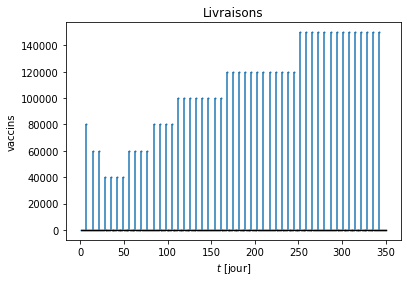

In [138]:
# Plot des livraisons
plt.figure()
plt.title("Livraisons")
markerline, stemlines, baseline = plt.stem(days, livraisons)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()   

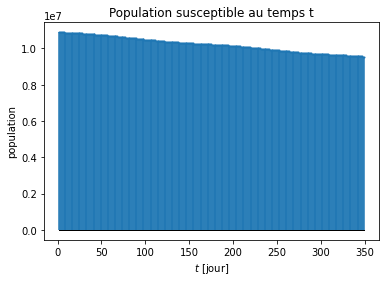

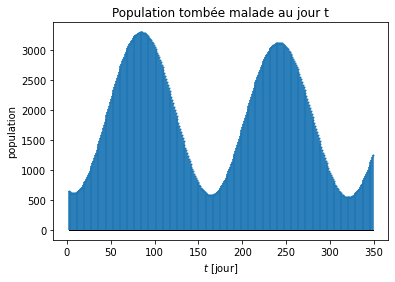

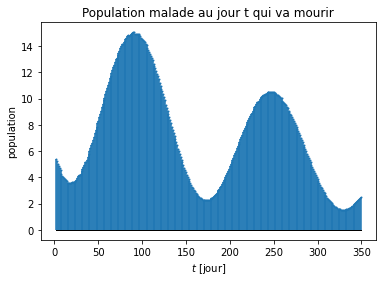

In [139]:
# Plot des populations
pop = [pop_s, pop_malade, pop_morte]
titres_pop = ["Population susceptible au temps t", "Population tombée malade au jour t", "Population malade au jour t qui va mourir"]
plt.figure()
for i in range(3):
    plt.title(titres_pop[i])
    markerline, stemlines, baseline = plt.stem(days[1:-1], pop[i])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("population", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()

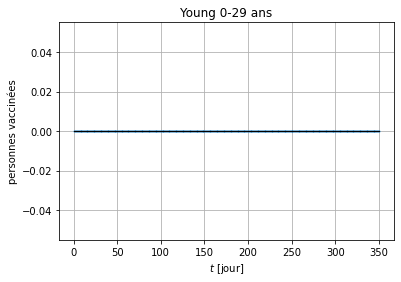

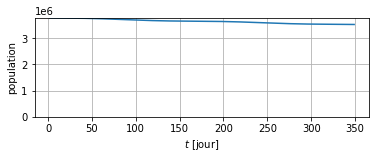

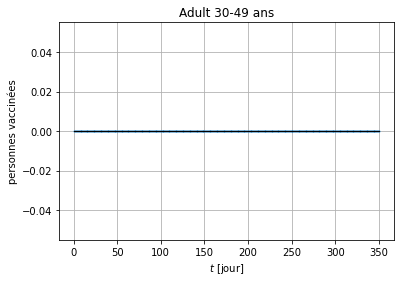

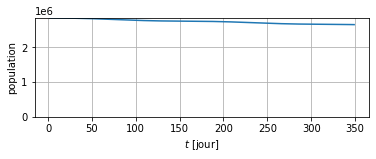

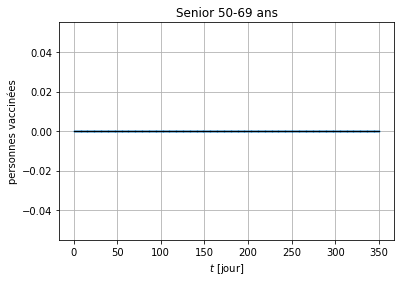

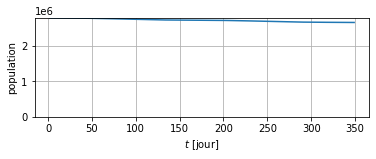

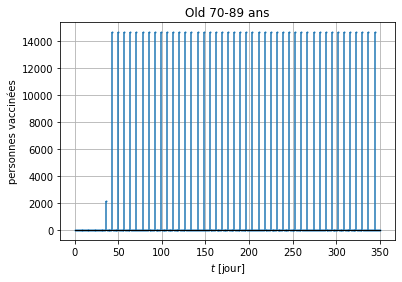

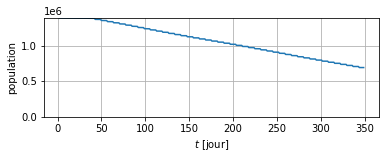

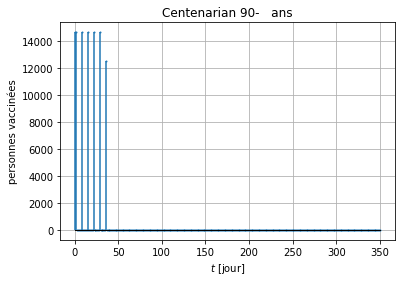

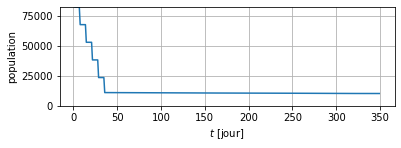

In [140]:
# Titres
titres = [f"{population[i]}" for i in range(m)]

plt.figure("Question 1.1")
for i in range(5):
        plt.subplot(1, 1, 1)
        plt.title(titres[i])
        markerline, stemlines, baseline = plt.stem(days, vaccination[i])       
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("personnes vaccinées", fontsize=10)

        baseline.set_color('k')
        baseline.set_linewidth(1)
        markerline.set_markersize(1)
        plt.grid()
        plt.show()
        
        plt.subplot(2, 1, 2)
        plt.plot(days[1:-1], susceptible[i])
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("population", fontsize=10)
        plt.ylim((0, max(susceptible[i])))
        plt.grid()
        plt.show()

### Question 1.2

On considère à présent le cas de $n$ provinces. Dans le cas de la Belgique, on aura $n=10$.
On autorise également le stockage des vaccins dans les centres.

Par rapport au modèle précédent, on introduit 
* $z_j^t \equiv$ le nombre de vaccins stockés au temps $t$ dans le centre de la province $j$, variable. Ces vaccins ne sont donc pas administrés au jour $t$.
* $(c_s)_j \equiv$ le coût associé au stockage d'un vaccin dans le centre $j$, connu.

Outre les contraintes identifiées plus haut, on ajoute le fait que tous les vaccins qui sont arrivés la veille ou qui étaient en stock la veille peuvent soit être administrés le lendemain, soit être mis en stock le lendemain.

Finalement, puisqu'on suppose que chaque province $j$ subit l'épidémie de manière indépendante, les contraintes sont propres à chacune, excepté les contraintes de coût total et de vaccins disponibles au hangar central.

De manière similaire qu'à la question 1.1, on prend la convention:
* $x^0 = 0 = x^T$, car aucun vaccin n'a été livré la veille du début de la campagne ou ne doit être livré le dernier jour.
* $z^0 = 0 = z^T$, car aucun vaccin n'est disponible en stock la veille du début de la campagne ou ne doit être mis en stock le dernier jour.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, z}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t (n_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left(c_{tr}\ x_j^t + c_v \sum_{i=1}^{m} y_{ij}^t + c_s z_j^t\right) &\leq& c_{tot} \\
x_j^{t-1} + z_j^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \\ 
x_j^t &\leq& (b_l)_j^t \\
\sum_{i=1}^{m} y_{ij}^t &\leq&\ (b_v)_j^t \\
\sum_{k=1}^t y_{ij}^k &\leq& \mu_{ij}\ (n_s)_{ij}^0 \\
x,\ y,\ z &\geq& 0
\end{eqnarray*}$$

Dans les données fournies, $\lambda_{ij}^t$ est indépendante du temps. L'équation de récurrence trouvée au point $1$ peut alors se simplifier comme:

$$\begin{eqnarray*}
(n_s)_{ij}^t &=& (1-\lambda_{ij}) (n_s)_{ij}^{t-1} - y_{ij}^{t-1} \\
&=& (n_s)_{ij}^{0}\ \exp_{1-\lambda_{ij}}(t) - \sum_{k=0}^{t-1} y_{ij}^{t-1-k}\ \exp_{1-\lambda_{ij}}(k)
\end{eqnarray*}$$


In [153]:
# Données du problème
_lambda = pd.read_csv("Données-v1.1/Fraction_malade_province.csv")
_lambda = _lambda.set_index('Tranche')

population_Province = pd.read_csv("Données-v1.1/Population_province.csv")

# Données du problème
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
n = 10                # Nombre de provinces
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_s   = 0             # Coût de stockage
c_tot = 100e6         # budget total autorisé
b_l   = float("inf")  # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

print(type(population_Province))
_lambda

# A supprimer prochainement :
# arrays = [population_Province["Province"], population_Province["Tranche"]]
# index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=["Province","Tranche"])
# population_Province = pd.Series(population_Province["Population"].to_numpy(),index)

<class 'pandas.core.frame.DataFrame'>


,Province de Flandre orientale,Province de Flandre occidentale,Province du Brabant flamand,Province d’Anvers,Province du Hainaut,Province de Liège,Province du Limbourg,Province du Luxembourg,Province du Brabant wallon,Province de Namur,Bruxelles
Tranche,,,,,,,,,,,
young,0.000298,0.000219,0.000223,0.000184,0.000218,0.000122,0.000147,0.000268,0.000286,0.000249,0.000185
adult,0.000301,0.000261,0.000219,0.000241,0.000283,0.000146,0.000160,0.000288,0.000306,0.000274,0.000313
senior,0.000204,0.000176,0.000130,0.000159,0.000220,0.000122,0.000117,0.000194,0.000229,0.000230,0.000291
old,0.000209,0.000164,0.000089,0.000122,0.000230,0.000131,0.000094,0.000127,0.000203,0.000194,0.000220
centanarian,0.000329,0.000180,0.000207,0.000079,0.000132,0.000227,0.000019,0.000400,0.000612,0.000160,0.000311


In [154]:
# Fonctions utiles à l'algorithme

def init_variables(model, m, n, t):
    """
    Initialise les variables x,y,z au format: x[t][j], y[t][j][i], z[t][j].
    
    @args: 
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
    
    @returns:
        x: List[List[Var]]: variables de livraison
        y: List[List[List[Var]]]: variables d'administration des vaccins
        z: List[List[Var]]: variables de stockage
    """
    # A supprimer prochainement :
    # x = []
    # z = []
    # y = []
    # for t in days-1:
    #     x.append([])
    #     z.append([])
    #     y.append([])
    #    for j in range(n):
    #        x[t].append(model.add_var())
    #         z[t].append(model.add_var())
    #         y[t].append([])
    #         for i in range(m):
    #             y[t][j].append(model.add_var())
    
    
    x = model.add_var_tensor((t, n), 'x')
    y = model.add_var_tensor((t, n, m), 'y')
    z = model.add_var_tensor((t, n), 'z')
    
    return x,y,z

def init_population(y, _lambda, population_Province):
    """
    Initialise la population de susceptibles au format: n_s[t][j][i].
    
    @args: 
        y: List[List[List[Var]]]: variables d'administration des vaccins
        _lambda: pandas DataFrame: données sur la fraction des malades
        population_Province: pandas DataFrame: données sur la population initiale dans chaque province.
    
    @returns: 
        n_s: List[List[List[Var]]]: population de susceptibles dans chaque province pour tout t.
        province: List[String]: noms des provinces.
        tranche: List[String]: noms des tranches
    """
    province = _lambda.columns.to_numpy()
    tranche =  _lambda.index.to_numpy()
    pop = population_Province["Population"].to_numpy()        
    n_s = [[[pop[i+m*j] for i in range(m)] for j in range(n)]]
    for t in range(1, len(days)):
        array = [[(1 - _lambda[province[j]][tranche[i]]) * n_s[t-1][j][i] - y[t-1][j][i] for i in range(m)] for j in range(n)]
        n_s.append(array)
    
    return n_s, province, tranche    

In [155]:
# A supprimer prochainement :
# x = [[model.add_var(var_type=INTEGER, lb=0) for t in days-1] for j in range(n)]
# y = [[[model.add_var(var_type=INTEGER, lb=0) for t in days-1] for i in range(m)] for j in range(n)]
# z = [[model.add_var(var_type=INTEGER, lb=0) for t in days-1] for j in range(n)]

# Résolution du problème
model = Model('multi-centre', sense=MINIMIZE, solver_name=CBC)
model.clear() # On clear pour être sûr que le modèle soit réinitialisé comme il faut

# Initialisation des variables
x,y,z = init_variables(model, m, n, len(days))
n_s, province, tranche = init_population(y, _lambda, population_Province)

# A supprimer prochainement :
# print("x:", len(x), len(x[0]))
# print("y:", len(y), len(y[0]), len(y[0][0]))
# print("z:", len(z), len(z[0]))

# Objectif
model.objective = minimize(xsum(_epsilon[i,t] * _lambda[province[j]][tranche[i]] * n_s[t-1][j][i] 
                                for i in range(m) for j in range(n) for t in days[1:-1]))

# Contrainte sur le coût total
model +=  xsum(c_tr * x[t][j] for j in range(n) for t in days-1) \
        + xsum(c_v * y[t][j][i] for i in range(m) for j in range(n) for t in days-1) \
        + xsum(c_s * z[t][j] for j in range(n) for t in days-1) <= c_tot

# On ne peut stocker ou administrer aucun vaccin le premier jour.
for j in range(n):   
    model += z[0][j] == 0
    for i in range(m):
        model += y[0][j][i] == 0
    
for t in days-1:   
    # Contrainte sur la quantité de vaccins livrables au temps t
    model += xsum(x[t][j] for j in range(n)) <= b_c[t]
    for j in range(n):   
        if t >= 1: 
            # Contrainte sur la quantité de vaccins disponibles et stockables au temps t
            model += x[t-1][j] + z[t-1][j] - xsum(y[t][j][i] for i in range(m)) - z[t][j] >= 0
            
        # Contrainte sur le nombre de vaccins administrables au temps t
        model += xsum(y[t][j][i] for i in range(m)) <= b_v # b_v est commun a toutes les provinces
        for i in range(m):
            # Contrainte sur le nombre de personnes vaccinables au temps t
            model += xsum(y[k][j][i] for k in range(t)) - mu[i] * n_s[0][j][i]  <= 0

model.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [156]:
print(f"f(x,y,z) = {model.objective_value}")

f(x,y,z) = 19080.03552867285


In [157]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [[x[t][j].x for t in days-1] for j in range(n)]
vaccination = [sum(y[t][j][i].x for j in range(n) for i in range(m)) for t in days-1]
stockage = [[z[t][j].x for t in days-1] for j in range(n)]

population = [sum(n_s[t-1][j][i].x for j in range(n) for i in range(m)) for t in days[1:-1]]
pop_morte  = [sum(_epsilon[i,t] * _lambda[province[j]][tranche[i]] * n_s[t-1][j][i].x for j in range(n) for i in range(m)) for t in days[1:-1]]


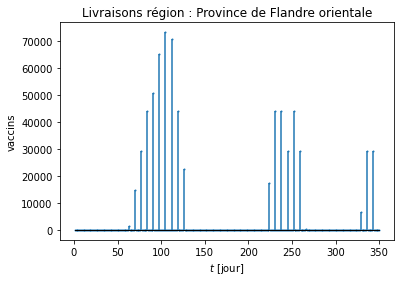

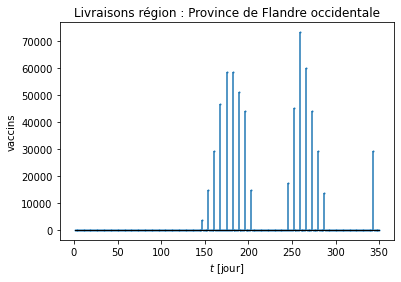

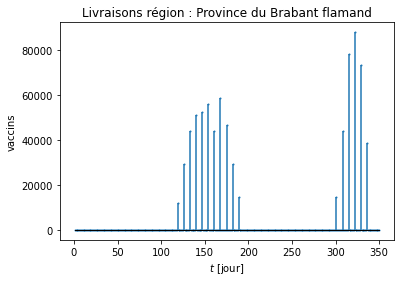

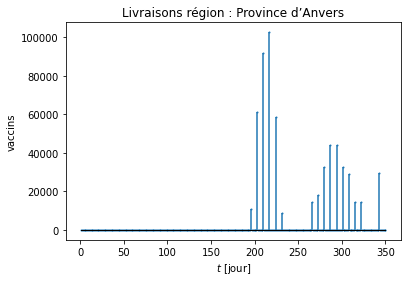

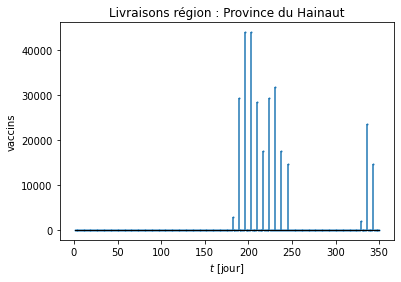

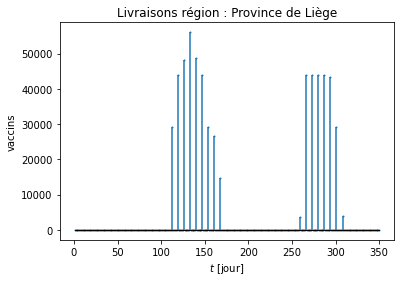

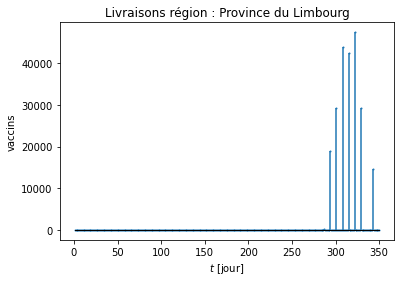

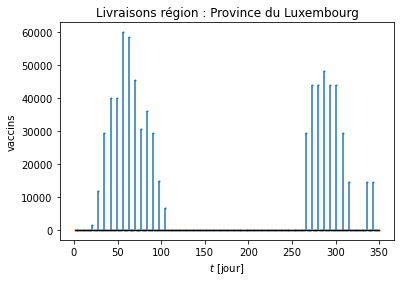

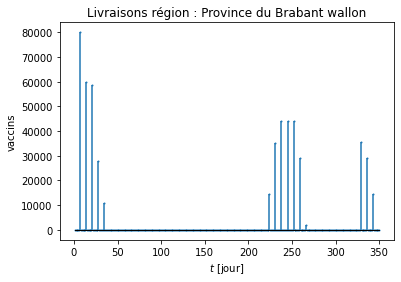

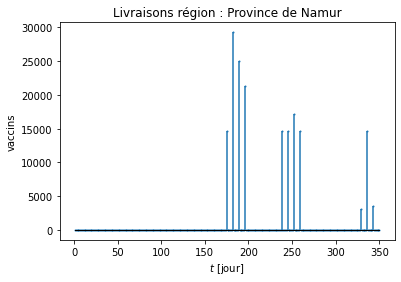

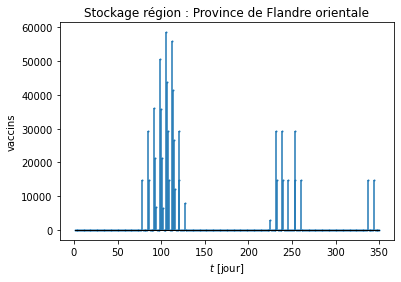

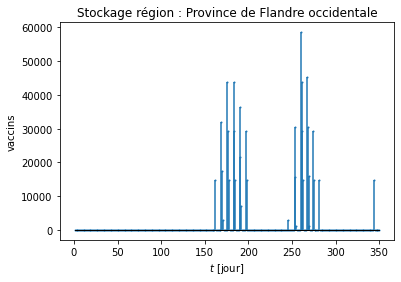

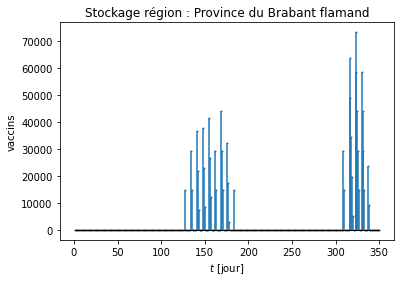

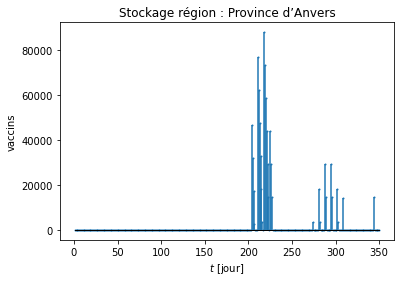

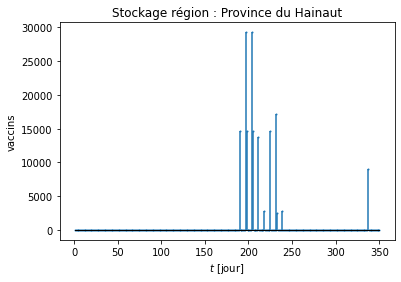

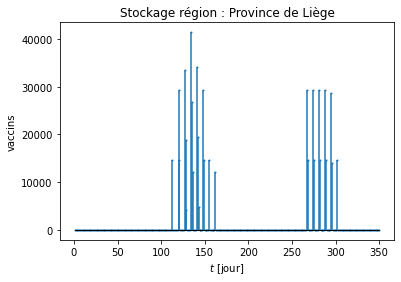

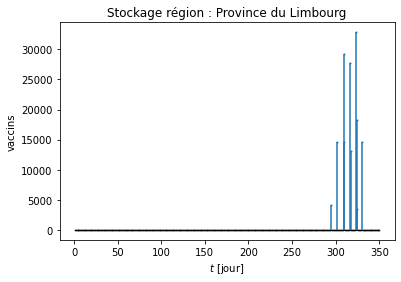

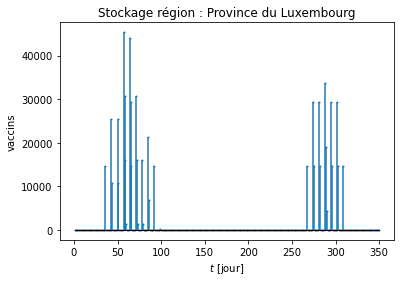

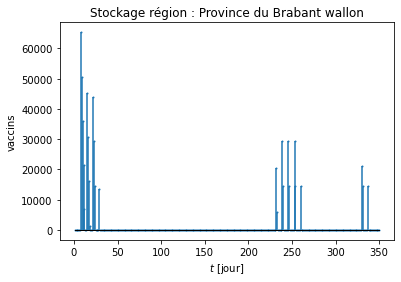

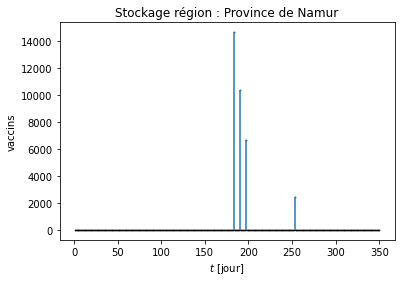

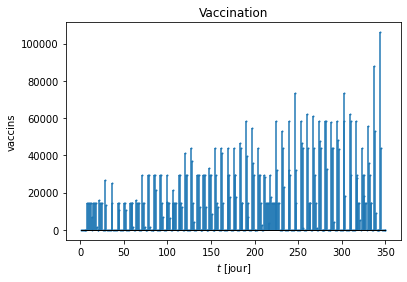

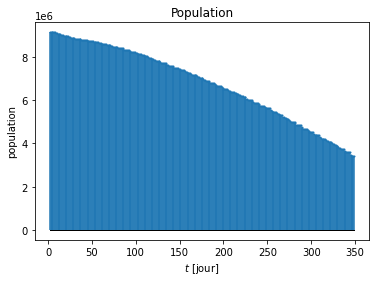

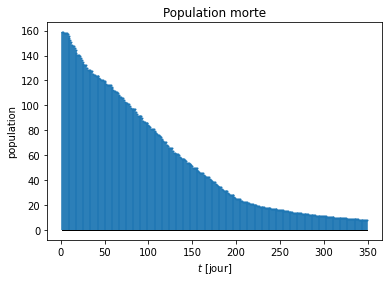

In [158]:
# Plot des livraisons
for j in range(n):
    plt.figure(j)
    plt.title(f"Livraisons région : {province[j]}")
    markerline, stemlines, baseline = plt.stem(days, livraisons[:][j])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()

# Plot du stockage
for j in range(n):
    plt.figure(j)
    plt.title(f"Stockage région : {province[j]}")
    markerline, stemlines, baseline = plt.stem(days, stockage[:][j])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()
    
# Plot des vaccinations
plt.figure()
plt.title(f"Vaccination")
markerline, stemlines, baseline = plt.stem(days, vaccination)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  

# Plot de la population
plt.figure()
plt.title(f"Population")
markerline, stemlines, baseline = plt.stem(days[1:-1], population)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("population", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  


# Plot de la population morte
plt.figure()
plt.title(f"Population morte")
markerline, stemlines, baseline = plt.stem(days[1:-1], pop_morte)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("population", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  

In [160]:
# print(stockage)